# Import

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ExponentialLR
import sys, os

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname("src"))))

from src.Mydataloader import LoadDataset
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining
from src.Earlystopper import EarlyStopper
from src.LogViewer import LogViewer

# Setup

In [2]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Dataset parameters"""
BATCH = 128
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True

"""optimizer parameters"""
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"
# OPTIMIZER = "SGD"
# OPTIMIZER = "SGD_nasterov"
# OPTIMIZER = "AdamW"
# OPTIMIZER = "AdamW_amsgrad"
OPTIMIZER = "NAdam"

"""Learning rate scheduler parameters"""
NUM_EPOCHS = 100

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 100

file_name = f"MyResNet32_{BATCH}_{OPTIMIZER}"

In [3]:
file_name

'MyResNet32_128_NAdam'

# Loading the dataset

## Define Dateloader

In [4]:
tmp = LoadDataset(root="../../../data", seceted_dataset=DATASET)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

/home/lee/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  50000
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [5]:
train_dataloader, valid_dataloader, test_dataloader = tmp.get_dataloader(
    batch_size=BATCH, shuffle=SHUFFLE, num_workers=NUMOFWORKERS, pin_memory=PIN_MEMORY
)

train.transforms = Compose(
      AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10)
      RandomCrop(size=(32, 32), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant)
      RandomHorizontalFlip(p=0.5)
      ToTensor()
      Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[1, 1, 1], inplace=True)
) 128
test.transforms = ToTensor() 128


# Define ResNet

## Model Confirm

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
model = MyResNet_CIFAR(num_classes=COUNT_OF_CLASSES, num_layer_factor=5).to(device)

# Define Training

## (1) Define Criterion

In [8]:
criterion = nn.CrossEntropyLoss()

## (2) Define Optimazer

In [9]:
if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4
    )
elif OPTIMIZER == "SGD_nasterov":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4, nesterov=True
    )
elif OPTIMIZER == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "AdamW_amsgrad":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4, amsgrad=True)
elif OPTIMIZER == "NAdam":
    optimizer = torch.optim.NAdam(model.parameters(), weight_decay=1e-4)

## (3) Define Early Stopping

In [10]:
earlystopper = EarlyStopper(patience=EARLYSTOPPINGPATIENCE, model=model, file_name=file_name)

## (4) Define Learning Rate schedualer

In [11]:
scheduler = ExponentialLR(optimizer, gamma=0.95)

## (5) Define AMP scaler

In [12]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [13]:
if os.path.exists(file_name + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        file_name + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    earlystopper.load_state_dict(checkpoint["earlystopper"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_name)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []
    lr_log = []
    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "lr_log": lr_log,
    }
    print("File does not exist. Created a new log.")

File does not exist. Created a new log.


In [14]:
optimizer.param_groups[0]["lr"]

0.002

In [15]:
earlystopper.early_stop_counter

0

# [Training Loop]

In [16]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    earlystopper=earlystopper,
    device=device,
    logs=logs,
    file_path=file_name,
)
pre_epochs = len(Training.logs["train_loss"])

for epoch in range(NUM_EPOCHS):
    now = epoch + 1 + pre_epochs
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    Training.Save()

    
    
    if earlystopper.check(eval_loss) == True:
        break

    print("-" * 50)

[Epoch 1/100] :


1 Train: 100%|███████| 391/391 [00:36<00:00, 10.69it/s]

Train Loss: 1.6367 | Train Acc: 40.32%


Test  Loss: 1.9274 | Test Acc: 43.15%
updated best eval loss : 1.92742022532451
--------------------------------------------------
[Epoch 2/100] :


2 Train: 100%|███████| 391/391 [00:31<00:00, 12.31it/s]


Train Loss: 1.1612 | Train Acc: 58.91%
Test  Loss: 2.5605 | Test Acc: 36.00%
--------------------------------------------------
[Epoch 3/100] :


3 Train: 100%|███████| 391/391 [00:31<00:00, 12.33it/s]


Train Loss: 0.9781 | Train Acc: 65.71%
Test  Loss: 1.0187 | Test Acc: 64.52%
updated best eval loss : 1.0187294973602778
--------------------------------------------------
[Epoch 4/100] :


4 Train: 100%|███████| 391/391 [00:30<00:00, 12.75it/s]


Train Loss: 0.8813 | Train Acc: 69.46%
Test  Loss: 1.2921 | Test Acc: 60.45%
--------------------------------------------------
[Epoch 5/100] :


5 Train: 100%|███████| 391/391 [00:30<00:00, 12.72it/s]


Train Loss: 0.8020 | Train Acc: 72.17%
Test  Loss: 0.9431 | Test Acc: 68.28%
updated best eval loss : 0.9431082202663904
--------------------------------------------------
[Epoch 6/100] :


6 Train: 100%|███████| 391/391 [00:30<00:00, 12.69it/s]


Train Loss: 0.7583 | Train Acc: 73.67%
Test  Loss: 0.8708 | Test Acc: 70.34%
updated best eval loss : 0.8708186587200889
--------------------------------------------------
[Epoch 7/100] :


7 Train: 100%|███████| 391/391 [00:29<00:00, 13.42it/s]


Train Loss: 0.7195 | Train Acc: 74.91%
Test  Loss: 0.8331 | Test Acc: 72.51%
updated best eval loss : 0.8331294572806056
--------------------------------------------------
[Epoch 8/100] :


8 Train: 100%|███████| 391/391 [00:32<00:00, 12.18it/s]


Train Loss: 0.6852 | Train Acc: 76.25%
Test  Loss: 0.8886 | Test Acc: 69.35%
--------------------------------------------------
[Epoch 9/100] :


9 Train: 100%|███████| 391/391 [00:38<00:00, 10.26it/s]


Train Loss: 0.6756 | Train Acc: 76.62%
Test  Loss: 0.6501 | Test Acc: 78.12%
updated best eval loss : 0.6501084566116333
--------------------------------------------------
[Epoch 10/100] :


10 Train: 100%|██████| 391/391 [00:50<00:00,  7.68it/s]


Train Loss: 0.6444 | Train Acc: 77.66%
Test  Loss: 0.8338 | Test Acc: 73.39%
--------------------------------------------------
[Epoch 11/100] :


11 Train: 100%|██████| 391/391 [00:48<00:00,  8.06it/s]


Train Loss: 0.6298 | Train Acc: 78.03%
Test  Loss: 0.7566 | Test Acc: 75.42%
--------------------------------------------------
[Epoch 12/100] :


12 Train: 100%|██████| 391/391 [00:36<00:00, 10.69it/s]


Train Loss: 0.6117 | Train Acc: 78.65%
Test  Loss: 0.6758 | Test Acc: 76.96%
--------------------------------------------------
[Epoch 13/100] :


13 Train: 100%|██████| 391/391 [00:35<00:00, 11.15it/s]


Train Loss: 0.6019 | Train Acc: 79.20%
Test  Loss: 0.6799 | Test Acc: 77.07%
--------------------------------------------------
[Epoch 14/100] :


14 Train: 100%|██████| 391/391 [00:35<00:00, 11.04it/s]


Train Loss: 0.5847 | Train Acc: 79.82%
Test  Loss: 0.8497 | Test Acc: 71.92%
--------------------------------------------------
[Epoch 15/100] :


15 Train: 100%|██████| 391/391 [00:36<00:00, 10.68it/s]


Train Loss: 0.5657 | Train Acc: 80.38%
Test  Loss: 0.6423 | Test Acc: 77.52%
updated best eval loss : 0.6422852749311472
--------------------------------------------------
[Epoch 16/100] :


16 Train: 100%|██████| 391/391 [00:35<00:00, 11.04it/s]


Train Loss: 0.5663 | Train Acc: 80.41%
Test  Loss: 0.6498 | Test Acc: 78.12%
--------------------------------------------------
[Epoch 17/100] :


17 Train: 100%|██████| 391/391 [00:35<00:00, 11.00it/s]


Train Loss: 0.5604 | Train Acc: 80.44%
Test  Loss: 0.6374 | Test Acc: 78.36%
updated best eval loss : 0.6374085896377322
--------------------------------------------------
[Epoch 18/100] :


18 Train: 100%|██████| 391/391 [00:35<00:00, 11.04it/s]


Train Loss: 0.5467 | Train Acc: 81.10%
Test  Loss: 0.5508 | Test Acc: 81.39%
updated best eval loss : 0.5508429951305631
--------------------------------------------------
[Epoch 19/100] :


19 Train: 100%|██████| 391/391 [00:34<00:00, 11.24it/s]


Train Loss: 0.5434 | Train Acc: 81.09%
Test  Loss: 0.6347 | Test Acc: 78.80%
--------------------------------------------------
[Epoch 20/100] :


20 Train: 100%|██████| 391/391 [00:35<00:00, 10.96it/s]


Train Loss: 0.5346 | Train Acc: 81.39%
Test  Loss: 0.6309 | Test Acc: 79.31%
--------------------------------------------------
[Epoch 21/100] :


21 Train: 100%|██████| 391/391 [00:36<00:00, 10.63it/s]


Train Loss: 0.5276 | Train Acc: 81.76%
Test  Loss: 0.5777 | Test Acc: 81.11%
--------------------------------------------------
[Epoch 22/100] :


22 Train: 100%|██████| 391/391 [00:51<00:00,  7.64it/s]


Train Loss: 0.5179 | Train Acc: 81.96%
Test  Loss: 0.5045 | Test Acc: 83.43%
updated best eval loss : 0.504495730505714
--------------------------------------------------
[Epoch 23/100] :


23 Train: 100%|██████| 391/391 [00:51<00:00,  7.60it/s]


Train Loss: 0.5096 | Train Acc: 82.30%
Test  Loss: 0.6084 | Test Acc: 79.12%
--------------------------------------------------
[Epoch 24/100] :


24 Train: 100%|██████| 391/391 [00:51<00:00,  7.60it/s]


Train Loss: 0.5083 | Train Acc: 82.41%
Test  Loss: 0.5670 | Test Acc: 80.69%
--------------------------------------------------
[Epoch 25/100] :


25 Train: 100%|██████| 391/391 [00:49<00:00,  7.88it/s]


Train Loss: 0.5033 | Train Acc: 82.64%
Test  Loss: 0.5623 | Test Acc: 81.07%
--------------------------------------------------
[Epoch 26/100] :


26 Train: 100%|██████| 391/391 [00:52<00:00,  7.50it/s]


Train Loss: 0.4953 | Train Acc: 82.78%
Test  Loss: 0.4944 | Test Acc: 83.47%
updated best eval loss : 0.49436076758783076
--------------------------------------------------
[Epoch 27/100] :


27 Train: 100%|██████| 391/391 [00:51<00:00,  7.55it/s]


Train Loss: 0.4929 | Train Acc: 82.76%
Test  Loss: 0.5164 | Test Acc: 82.64%
--------------------------------------------------
[Epoch 28/100] :


28 Train: 100%|██████| 391/391 [00:50<00:00,  7.68it/s]


Train Loss: 0.4900 | Train Acc: 82.88%
Test  Loss: 0.4967 | Test Acc: 83.75%
--------------------------------------------------
[Epoch 29/100] :


29 Train: 100%|██████| 391/391 [00:52<00:00,  7.48it/s]


Train Loss: 0.4840 | Train Acc: 83.22%
Test  Loss: 0.6267 | Test Acc: 79.75%
--------------------------------------------------
[Epoch 30/100] :


30 Train: 100%|██████| 391/391 [00:50<00:00,  7.67it/s]


Train Loss: 0.4869 | Train Acc: 83.09%
Test  Loss: 0.5397 | Test Acc: 82.05%
--------------------------------------------------
[Epoch 31/100] :


31 Train: 100%|██████| 391/391 [00:52<00:00,  7.46it/s]


Train Loss: 0.4800 | Train Acc: 83.42%
Test  Loss: 0.6310 | Test Acc: 79.28%
--------------------------------------------------
[Epoch 32/100] :


32 Train: 100%|██████| 391/391 [00:50<00:00,  7.67it/s]


Train Loss: 0.4738 | Train Acc: 83.58%
Test  Loss: 0.5753 | Test Acc: 81.06%
--------------------------------------------------
[Epoch 33/100] :


33 Train: 100%|██████| 391/391 [00:53<00:00,  7.37it/s]


Train Loss: 0.4779 | Train Acc: 83.31%
Test  Loss: 0.4839 | Test Acc: 83.98%
updated best eval loss : 0.48393184210680706
--------------------------------------------------
[Epoch 34/100] :


34 Train: 100%|██████| 391/391 [00:51<00:00,  7.64it/s]


Train Loss: 0.4710 | Train Acc: 83.61%
Test  Loss: 0.6251 | Test Acc: 79.81%
--------------------------------------------------
[Epoch 35/100] :


35 Train: 100%|██████| 391/391 [00:51<00:00,  7.55it/s]


Train Loss: 0.4679 | Train Acc: 83.80%
Test  Loss: 0.5447 | Test Acc: 81.77%
--------------------------------------------------
[Epoch 36/100] :


36 Train: 100%|██████| 391/391 [00:50<00:00,  7.73it/s]


Train Loss: 0.4673 | Train Acc: 83.73%
Test  Loss: 0.5323 | Test Acc: 82.48%
--------------------------------------------------
[Epoch 37/100] :


37 Train: 100%|██████| 391/391 [00:50<00:00,  7.70it/s]


Train Loss: 0.4607 | Train Acc: 84.00%
Test  Loss: 0.4728 | Test Acc: 83.84%
updated best eval loss : 0.4727765102929707
--------------------------------------------------
[Epoch 38/100] :


38 Train: 100%|██████| 391/391 [00:51<00:00,  7.66it/s]


Train Loss: 0.4583 | Train Acc: 84.13%
Test  Loss: 0.5368 | Test Acc: 81.53%
--------------------------------------------------
[Epoch 39/100] :


39 Train: 100%|██████| 391/391 [00:49<00:00,  7.97it/s]


Train Loss: 0.4516 | Train Acc: 84.29%
Test  Loss: 0.4641 | Test Acc: 84.34%
updated best eval loss : 0.46410794084585166
--------------------------------------------------
[Epoch 40/100] :


40 Train: 100%|██████| 391/391 [00:51<00:00,  7.64it/s]


Train Loss: 0.4519 | Train Acc: 84.31%
Test  Loss: 0.5329 | Test Acc: 82.06%
--------------------------------------------------
[Epoch 41/100] :


41 Train: 100%|██████| 391/391 [00:50<00:00,  7.77it/s]


Train Loss: 0.4555 | Train Acc: 84.19%
Test  Loss: 0.4960 | Test Acc: 83.21%
--------------------------------------------------
[Epoch 42/100] :


42 Train: 100%|██████| 391/391 [00:51<00:00,  7.59it/s]


Train Loss: 0.4508 | Train Acc: 84.48%
Test  Loss: 0.4583 | Test Acc: 84.33%
updated best eval loss : 0.45831095493292506
--------------------------------------------------
[Epoch 43/100] :


43 Train: 100%|██████| 391/391 [00:48<00:00,  8.04it/s]


Train Loss: 0.4447 | Train Acc: 84.46%
Test  Loss: 0.4448 | Test Acc: 84.67%
updated best eval loss : 0.4447710887540745
--------------------------------------------------
[Epoch 44/100] :


44 Train: 100%|██████| 391/391 [00:51<00:00,  7.54it/s]


Train Loss: 0.4428 | Train Acc: 84.65%
Test  Loss: 0.5143 | Test Acc: 82.86%
--------------------------------------------------
[Epoch 45/100] :


45 Train: 100%|██████| 391/391 [00:51<00:00,  7.52it/s]


Train Loss: 0.4428 | Train Acc: 84.46%
Test  Loss: 0.4823 | Test Acc: 83.41%
--------------------------------------------------
[Epoch 46/100] :


46 Train: 100%|██████| 391/391 [00:50<00:00,  7.74it/s]


Train Loss: 0.4489 | Train Acc: 84.45%
Test  Loss: 0.4956 | Test Acc: 83.70%
--------------------------------------------------
[Epoch 47/100] :


47 Train: 100%|██████| 391/391 [00:52<00:00,  7.46it/s]


Train Loss: 0.4384 | Train Acc: 84.75%
Test  Loss: 0.5788 | Test Acc: 81.58%
--------------------------------------------------
[Epoch 48/100] :


48 Train: 100%|██████| 391/391 [00:47<00:00,  8.25it/s]


Train Loss: 0.4342 | Train Acc: 84.84%
Test  Loss: 0.4616 | Test Acc: 84.36%
--------------------------------------------------
[Epoch 49/100] :


49 Train: 100%|██████| 391/391 [00:50<00:00,  7.79it/s]


Train Loss: 0.4356 | Train Acc: 85.00%
Test  Loss: 0.5179 | Test Acc: 82.42%
--------------------------------------------------
[Epoch 50/100] :


50 Train: 100%|██████| 391/391 [00:50<00:00,  7.76it/s]


Train Loss: 0.4352 | Train Acc: 84.90%
Test  Loss: 0.4516 | Test Acc: 84.43%
--------------------------------------------------
[Epoch 51/100] :


51 Train: 100%|██████| 391/391 [00:52<00:00,  7.40it/s]


Train Loss: 0.4336 | Train Acc: 84.85%
Test  Loss: 0.4355 | Test Acc: 85.53%
updated best eval loss : 0.43553274454949775
--------------------------------------------------
[Epoch 52/100] :


52 Train: 100%|██████| 391/391 [00:50<00:00,  7.72it/s]


Train Loss: 0.4326 | Train Acc: 85.08%
Test  Loss: 0.4295 | Test Acc: 85.46%
updated best eval loss : 0.4294545580691929
--------------------------------------------------
[Epoch 53/100] :


53 Train: 100%|██████| 391/391 [00:51<00:00,  7.56it/s]


Train Loss: 0.4348 | Train Acc: 84.75%
Test  Loss: 0.4813 | Test Acc: 83.75%
--------------------------------------------------
[Epoch 54/100] :


54 Train: 100%|██████| 391/391 [00:51<00:00,  7.64it/s]


Train Loss: 0.4270 | Train Acc: 85.22%
Test  Loss: 0.5330 | Test Acc: 82.87%
--------------------------------------------------
[Epoch 55/100] :


55 Train: 100%|██████| 391/391 [00:50<00:00,  7.76it/s]


Train Loss: 0.4290 | Train Acc: 85.06%
Test  Loss: 0.4936 | Test Acc: 83.27%
--------------------------------------------------
[Epoch 56/100] :


56 Train: 100%|██████| 391/391 [00:50<00:00,  7.68it/s]


Train Loss: 0.4293 | Train Acc: 85.13%
Test  Loss: 0.4876 | Test Acc: 83.64%
--------------------------------------------------
[Epoch 57/100] :


57 Train: 100%|██████| 391/391 [00:50<00:00,  7.71it/s]


Train Loss: 0.4200 | Train Acc: 85.54%
Test  Loss: 0.4578 | Test Acc: 83.89%
--------------------------------------------------
[Epoch 58/100] :


58 Train: 100%|██████| 391/391 [00:51<00:00,  7.54it/s]


Train Loss: 0.4275 | Train Acc: 85.18%
Test  Loss: 0.4441 | Test Acc: 84.78%
--------------------------------------------------
[Epoch 59/100] :


59 Train: 100%|██████| 391/391 [00:48<00:00,  8.05it/s]


Train Loss: 0.4244 | Train Acc: 85.24%
Test  Loss: 0.4946 | Test Acc: 83.45%
--------------------------------------------------
[Epoch 60/100] :


60 Train: 100%|██████| 391/391 [00:51<00:00,  7.61it/s]


Train Loss: 0.4215 | Train Acc: 85.51%
Test  Loss: 0.4621 | Test Acc: 83.84%
--------------------------------------------------
[Epoch 61/100] :


61 Train: 100%|██████| 391/391 [00:49<00:00,  7.95it/s]


Train Loss: 0.4216 | Train Acc: 85.36%
Test  Loss: 0.5527 | Test Acc: 81.47%
--------------------------------------------------
[Epoch 62/100] :


62 Train: 100%|██████| 391/391 [00:51<00:00,  7.54it/s]


Train Loss: 0.4132 | Train Acc: 85.64%
Test  Loss: 0.4608 | Test Acc: 84.37%
--------------------------------------------------
[Epoch 63/100] :


63 Train: 100%|██████| 391/391 [00:50<00:00,  7.68it/s]


Train Loss: 0.4159 | Train Acc: 85.61%
Test  Loss: 0.5171 | Test Acc: 82.89%
--------------------------------------------------
[Epoch 64/100] :


64 Train: 100%|██████| 391/391 [00:51<00:00,  7.58it/s]


Train Loss: 0.4138 | Train Acc: 85.59%
Test  Loss: 0.5643 | Test Acc: 80.87%
--------------------------------------------------
[Epoch 65/100] :


65 Train: 100%|██████| 391/391 [00:50<00:00,  7.78it/s]


Train Loss: 0.4162 | Train Acc: 85.49%
Test  Loss: 0.5187 | Test Acc: 83.63%
--------------------------------------------------
[Epoch 66/100] :


66 Train: 100%|██████| 391/391 [00:49<00:00,  7.92it/s]


Train Loss: 0.4121 | Train Acc: 85.42%
Test  Loss: 0.4696 | Test Acc: 84.55%
--------------------------------------------------
[Epoch 67/100] :


67 Train: 100%|██████| 391/391 [00:52<00:00,  7.45it/s]


Train Loss: 0.4107 | Train Acc: 85.58%
Test  Loss: 0.4503 | Test Acc: 84.38%
--------------------------------------------------
[Epoch 68/100] :


68 Train: 100%|██████| 391/391 [00:48<00:00,  8.02it/s]


Train Loss: 0.4097 | Train Acc: 85.74%
Test  Loss: 0.4926 | Test Acc: 83.61%
--------------------------------------------------
[Epoch 69/100] :


69 Train: 100%|██████| 391/391 [00:48<00:00,  8.02it/s]


Train Loss: 0.4160 | Train Acc: 85.58%
Test  Loss: 0.4433 | Test Acc: 85.16%
--------------------------------------------------
[Epoch 70/100] :


70 Train: 100%|██████| 391/391 [00:49<00:00,  7.90it/s]


Train Loss: 0.4081 | Train Acc: 85.73%
Test  Loss: 0.4523 | Test Acc: 84.79%
--------------------------------------------------
[Epoch 71/100] :


71 Train: 100%|██████| 391/391 [00:50<00:00,  7.68it/s]


Train Loss: 0.4069 | Train Acc: 85.77%
Test  Loss: 0.5937 | Test Acc: 80.46%
--------------------------------------------------
[Epoch 72/100] :


72 Train: 100%|██████| 391/391 [00:51<00:00,  7.58it/s]


Train Loss: 0.4070 | Train Acc: 85.79%
Test  Loss: 0.4369 | Test Acc: 85.10%
--------------------------------------------------
[Epoch 73/100] :


73 Train: 100%|██████| 391/391 [00:50<00:00,  7.69it/s]


Train Loss: 0.4070 | Train Acc: 85.85%
Test  Loss: 0.5143 | Test Acc: 82.64%
--------------------------------------------------
[Epoch 74/100] :


74 Train: 100%|██████| 391/391 [00:49<00:00,  7.83it/s]


Train Loss: 0.4106 | Train Acc: 85.87%
Test  Loss: 0.4448 | Test Acc: 84.79%
--------------------------------------------------
[Epoch 75/100] :


75 Train: 100%|██████| 391/391 [00:50<00:00,  7.73it/s]


Train Loss: 0.4041 | Train Acc: 85.84%
Test  Loss: 0.4431 | Test Acc: 85.22%
--------------------------------------------------
[Epoch 76/100] :


76 Train: 100%|██████| 391/391 [00:51<00:00,  7.66it/s]


Train Loss: 0.4017 | Train Acc: 86.03%
Test  Loss: 0.5468 | Test Acc: 81.81%
--------------------------------------------------
[Epoch 77/100] :


77 Train: 100%|██████| 391/391 [00:50<00:00,  7.71it/s]


Train Loss: 0.4076 | Train Acc: 85.95%
Test  Loss: 0.4554 | Test Acc: 84.64%
--------------------------------------------------
[Epoch 78/100] :


78 Train: 100%|██████| 391/391 [00:51<00:00,  7.64it/s]


Train Loss: 0.4006 | Train Acc: 85.94%
Test  Loss: 0.4676 | Test Acc: 84.12%
--------------------------------------------------
[Epoch 79/100] :


79 Train: 100%|██████| 391/391 [00:49<00:00,  7.88it/s]


Train Loss: 0.4034 | Train Acc: 85.95%
Test  Loss: 0.4841 | Test Acc: 83.92%
--------------------------------------------------
[Epoch 80/100] :


80 Train: 100%|██████| 391/391 [00:49<00:00,  7.90it/s]


Train Loss: 0.4013 | Train Acc: 86.00%
Test  Loss: 0.4642 | Test Acc: 84.45%
--------------------------------------------------
[Epoch 81/100] :


81 Train: 100%|██████| 391/391 [00:49<00:00,  7.84it/s]


Train Loss: 0.4011 | Train Acc: 86.06%
Test  Loss: 0.4677 | Test Acc: 84.51%
--------------------------------------------------
[Epoch 82/100] :


82 Train: 100%|██████| 391/391 [00:51<00:00,  7.67it/s]


Train Loss: 0.4007 | Train Acc: 85.96%
Test  Loss: 0.4648 | Test Acc: 84.89%
--------------------------------------------------
[Epoch 83/100] :


83 Train: 100%|██████| 391/391 [00:51<00:00,  7.55it/s]


Train Loss: 0.4013 | Train Acc: 85.86%
Test  Loss: 0.4849 | Test Acc: 83.70%
--------------------------------------------------
[Epoch 84/100] :


84 Train: 100%|██████| 391/391 [00:49<00:00,  7.96it/s]


Train Loss: 0.3901 | Train Acc: 86.39%
Test  Loss: 0.5033 | Test Acc: 83.51%
--------------------------------------------------
[Epoch 85/100] :


85 Train: 100%|██████| 391/391 [00:51<00:00,  7.52it/s]


Train Loss: 0.3991 | Train Acc: 86.10%
Test  Loss: 0.4894 | Test Acc: 83.17%
--------------------------------------------------
[Epoch 86/100] :


86 Train: 100%|██████| 391/391 [00:50<00:00,  7.81it/s]


Train Loss: 0.3953 | Train Acc: 86.15%
Test  Loss: 0.5846 | Test Acc: 81.03%
--------------------------------------------------
[Epoch 87/100] :


87 Train: 100%|██████| 391/391 [00:50<00:00,  7.68it/s]


Train Loss: 0.3976 | Train Acc: 86.18%
Test  Loss: 0.4583 | Test Acc: 84.40%
--------------------------------------------------
[Epoch 88/100] :


88 Train: 100%|██████| 391/391 [00:50<00:00,  7.73it/s]


Train Loss: 0.3935 | Train Acc: 86.50%
Test  Loss: 0.4274 | Test Acc: 85.45%
updated best eval loss : 0.42743571253517004
--------------------------------------------------
[Epoch 89/100] :


89 Train: 100%|██████| 391/391 [00:50<00:00,  7.82it/s]


Train Loss: 0.3936 | Train Acc: 86.20%
Test  Loss: 0.4910 | Test Acc: 83.79%
--------------------------------------------------
[Epoch 90/100] :


90 Train: 100%|██████| 391/391 [00:50<00:00,  7.68it/s]


Train Loss: 0.3942 | Train Acc: 86.32%
Test  Loss: 0.5584 | Test Acc: 81.39%
--------------------------------------------------
[Epoch 91/100] :


91 Train: 100%|██████| 391/391 [00:50<00:00,  7.67it/s]


Train Loss: 0.3895 | Train Acc: 86.50%
Test  Loss: 0.4994 | Test Acc: 83.67%
--------------------------------------------------
[Epoch 92/100] :


92 Train: 100%|██████| 391/391 [00:50<00:00,  7.78it/s]


Train Loss: 0.3934 | Train Acc: 86.19%
Test  Loss: 0.4305 | Test Acc: 85.53%
--------------------------------------------------
[Epoch 93/100] :


93 Train: 100%|██████| 391/391 [00:49<00:00,  7.85it/s]


Train Loss: 0.3968 | Train Acc: 86.30%
Test  Loss: 0.4893 | Test Acc: 83.72%
--------------------------------------------------
[Epoch 94/100] :


94 Train: 100%|██████| 391/391 [00:50<00:00,  7.75it/s]


Train Loss: 0.3911 | Train Acc: 86.37%
Test  Loss: 0.5364 | Test Acc: 82.08%
--------------------------------------------------
[Epoch 95/100] :


95 Train: 100%|██████| 391/391 [00:39<00:00,  9.97it/s]


Train Loss: 0.3920 | Train Acc: 86.42%
Test  Loss: 0.5300 | Test Acc: 82.77%
--------------------------------------------------
[Epoch 96/100] :


96 Train: 100%|██████| 391/391 [00:40<00:00,  9.59it/s]


Train Loss: 0.3869 | Train Acc: 86.50%
Test  Loss: 0.4658 | Test Acc: 84.04%
--------------------------------------------------
[Epoch 97/100] :


97 Train: 100%|██████| 391/391 [00:30<00:00, 12.85it/s]


Train Loss: 0.3904 | Train Acc: 86.14%
Test  Loss: 0.5023 | Test Acc: 82.73%
--------------------------------------------------
[Epoch 98/100] :


98 Train: 100%|██████| 391/391 [00:20<00:00, 19.27it/s]


Train Loss: 0.3895 | Train Acc: 86.44%
Test  Loss: 0.4863 | Test Acc: 83.38%
--------------------------------------------------
[Epoch 99/100] :


99 Train: 100%|██████| 391/391 [00:20<00:00, 18.85it/s]


Train Loss: 0.3883 | Train Acc: 86.53%
Test  Loss: 0.4856 | Test Acc: 83.59%
--------------------------------------------------
[Epoch 100/100] :


100 Train: 100%|█████| 391/391 [00:21<00:00, 17.80it/s]


Train Loss: 0.3872 | Train Acc: 86.48%
Test  Loss: 0.5737 | Test Acc: 80.91%
--------------------------------------------------


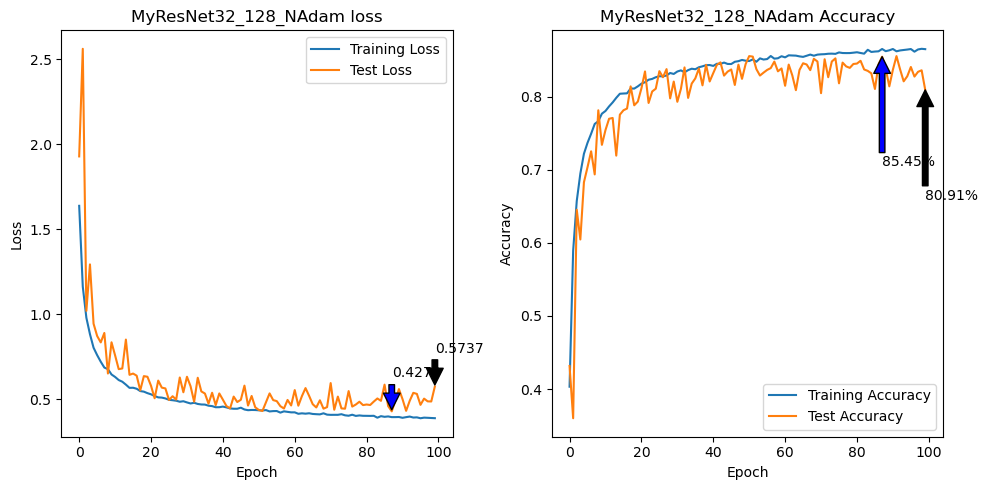

In [17]:
view = LogViewer(logs)
view.draw(save_name=file_name)

In [18]:
view.print_all()

1 epoch: train_loss=1.6367, train_acc=0.4032, test_loss=1.9274, test_acc=0.4315, lr=0.0020
2 epoch: train_loss=1.1612, train_acc=0.5891, test_loss=2.5605, test_acc=0.3600, lr=0.0020
3 epoch: train_loss=0.9781, train_acc=0.6571, test_loss=1.0187, test_acc=0.6452, lr=0.0020
4 epoch: train_loss=0.8813, train_acc=0.6946, test_loss=1.2921, test_acc=0.6045, lr=0.0020
5 epoch: train_loss=0.8020, train_acc=0.7217, test_loss=0.9431, test_acc=0.6828, lr=0.0020
6 epoch: train_loss=0.7583, train_acc=0.7367, test_loss=0.8708, test_acc=0.7034, lr=0.0020
7 epoch: train_loss=0.7195, train_acc=0.7491, test_loss=0.8331, test_acc=0.7251, lr=0.0020
8 epoch: train_loss=0.6852, train_acc=0.7625, test_loss=0.8886, test_acc=0.6935, lr=0.0020
9 epoch: train_loss=0.6756, train_acc=0.7662, test_loss=0.6501, test_acc=0.7812, lr=0.0020
10 epoch: train_loss=0.6444, train_acc=0.7766, test_loss=0.8338, test_acc=0.7339, lr=0.0020
11 epoch: train_loss=0.6298, train_acc=0.7803, test_loss=0.7566, test_acc=0.7542, lr=0.00